In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3" # set gpu number to use

from comet_ml import Experiment

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

%matplotlib inline

In [97]:
def load_dataset():
    data_path = '../../../data/pill/train/'
    train_dataset = dset.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.Resize((128,128)),
            transforms.ToTensor()
            ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=15,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [98]:
total_image = np.zeros((256,256))
for i, (img, _) in enumerate(load_dataset()):
    total_image =+ img[0].permute(1, 2, 0).numpy()

In [110]:
TOTAL_MEAN = total_image.mean(axis = (0,1))

In [111]:
TOTAL_STD = total_image.std(axis = (0,1))

In [185]:
def load_dataset():
    data_path = '../../../data/pill/train/'
    train_dataset = dset.ImageFolder(
        root=data_path,
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.Resize((128,128)),
            transforms.ToTensor(),
            transforms.Normalize(TOTAL_MEAN, TOTAL_STD)
            ])
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=5,
        num_workers=0,
        shuffle=True
    )
    return train_loader

In [154]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,256),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(1,8,3,2,1,1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(8,16,3,1,1),
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(16,32,3,2,1,1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.LeakyReLU()
        )
        self.layer4 = nn.Sequential(
                        nn.ConvTranspose2d(32,16,3,2,1,1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(16,3,3,1,1),
                        nn.Tanh(),
            )
            
        
    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],1,16,16)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        return out

In [155]:
from torchsummary import summary
gen = Generator().cuda()
summary(gen, (100,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
              ReLU-2                  [-1, 256]               0
   ConvTranspose2d-3            [-1, 8, 32, 32]              80
         LeakyReLU-4            [-1, 8, 32, 32]               0
   ConvTranspose2d-5           [-1, 16, 32, 32]           1,168
         LeakyReLU-6           [-1, 16, 32, 32]               0
   ConvTranspose2d-7           [-1, 32, 64, 64]           4,640
         LeakyReLU-8           [-1, 32, 64, 64]               0
   ConvTranspose2d-9           [-1, 32, 64, 64]           9,248
        LeakyReLU-10           [-1, 32, 64, 64]               0
  ConvTranspose2d-11         [-1, 16, 128, 128]           4,624
        LeakyReLU-12         [-1, 16, 128, 128]               0
  ConvTranspose2d-13          [-1, 3, 128, 128]             435
             Tanh-14          [-1, 3, 1

In [191]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()        
        self.layer2 = nn.Sequential(
                        nn.Conv2d(3,16,3,padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(16,16,3,padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
        )
        self.layer3 = nn.Sequential(
                        nn.Conv2d(16,32,3,padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(32,32,3,padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
        )
        self.layer4 = nn.Sequential(
                        nn.Conv2d(32,32,3,padding=1),
                        nn.LeakyReLU(),
                        nn.Conv2d(32,32,3,padding=1),
                        nn.LeakyReLU(),
                        nn.MaxPool2d(2,2),
        )


        self.fc = nn.Sequential(
                        nn.Linear(512,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer2(x)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [192]:
disc = Discriminator().cuda()
summary(disc, (3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             448
         LeakyReLU-2         [-1, 16, 128, 128]               0
         MaxPool2d-3           [-1, 16, 64, 64]               0
            Conv2d-4           [-1, 16, 64, 64]           2,320
         LeakyReLU-5           [-1, 16, 64, 64]               0
         MaxPool2d-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
         LeakyReLU-8           [-1, 32, 32, 32]               0
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           9,248
        LeakyReLU-11           [-1, 32, 16, 16]               0
        MaxPool2d-12             [-1, 32, 8, 8]               0
           Conv2d-13             [-1, 32, 8, 8]           9,248
        LeakyReLU-14             [-1, 3

In [211]:
import torch
from torchvision.utils import make_grid
from torchsummary import summary

def run_an_experiment(lr, n_epochs = 1, sample_interval = 20):
    experiment = Experiment(api_key = 'fcQ6lceLdmViH5KysjfD4mkz7', project_name='AnoGAN—MNIST', workspace='Sirius-yandex-2019')
    
    experiment.log_parameter('n_epochs', n_epochs)
    experiment.log_parameter('lr', lr)

    generator = Generator().to('cuda')
    discriminator = Discriminator().to('cuda')

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)

    Tensor = torch.cuda.FloatTensor

    adversarial_loss = torch.nn.BCELoss()

    batches_done = 0
    
    generator.train()
    discriminator.train()

    for epoch in range(n_epochs):

        for i, (imgs, _) in enumerate(load_dataset()):
            
            valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False).to('cuda')
            fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False).to('cuda')


            real_imgs = Variable(imgs.type(Tensor).cuda() + torch.randn(imgs.shape, device="cuda") * 0.05)

            optimizer_G.zero_grad()

            z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], 100)))).to('cuda')
            fake_imgs = generator(z)
            
            loss_G = adversarial_loss(discriminator(fake_imgs)[0], valid)
            loss_G.backward()
            nn.utils.clip_grad_norm_(generator.parameters(), 1)

            optimizer_G.step()
            
            
            optimizer_D.zero_grad()
            
            if i > 20:
                print()
            
            err_r = adversarial_loss(discriminator(real_imgs)[0], valid)
            err_z = adversarial_loss(discriminator(fake_imgs.detach())[0], fake)
            loss_D = (err_r + err_z) / 2

            loss_D.backward()
            nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
            
            optimizer_D.step()

            experiment.log_metrics({'G': loss_G.item(), 'D': loss_D.item()}, epoch = epoch, step = batches_done)

            if batches_done % sample_interval == 0:
                plt.figure(figsize = (10,10))

                plt.title(
                    "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                    % (epoch, n_epochs, batches_done % len(load_dataset()), len(load_dataset()), loss_D.item(), loss_G.item())
                )

                plt.imshow(make_grid(fake_imgs.data[:25]).cpu().detach().numpy()[0, :, :])
                experiment.log_figure()
                plt.show()
            batches_done += 1
            
        

    experiment.end()
    return generator, discriminator


COMET INFO: Experiment is live on comet.ml https://www.comet.ml/sirius-yandex-2019/anogan-mnist/1dcc9653286047b6a550a6a9b094c0e6



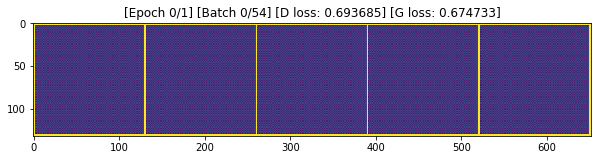

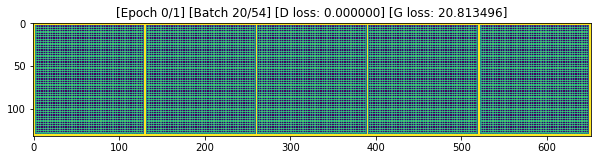

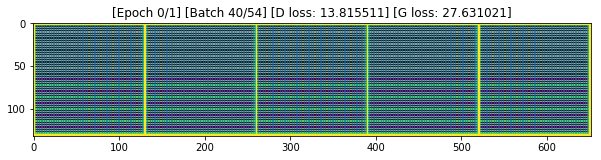

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/sirius-yandex-2019/anogan-mnist/1dcc9653286047b6a550a6a9b094c0e6
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     D [54]                   : (0.0, 13.815510749816895)
COMET INFO:     G [54]                   : (0.0, 67.4737777709961)
COMET INFO:     loss [11]                : (0.0, 27.63102149963379)
COMET INFO:     sys.gpu.0.free_memory    : (5230034944.0, 5230034944.0)
COMET INFO:     sys.gpu.0.gpu_utilization: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.0.used_memory    : (6765543424.0, 6765543424.0)
COMET INFO:     sys.gpu.1.free_memory    : (2035679232.0, 2035679232.0)
COMET INFO:     sys.gpu.1.gpu_utilization: (80.0, 80.0)
COMET INFO:     sys.gpu.1.total_memory   : (11995578368.0, 11995578368.0)
COMET INFO:     sys.gpu.1.used_memory    : (9959899136.0, 9959899136.0)

In [212]:
generator, discriminator = run_an_experiment(0.002)

In [213]:
for i, (imgs, _) in enumerate(load_dataset()):
    print(discriminator(imgs.type(torch.cuda.FloatTensor).cuda())[0])
    break

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<SigmoidBackward>)


In [ ]:
# Upsampling (bilinear)
# Instance noise
# Augmentations